# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf


Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 10

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
x = 30 # number of frames
y = 120 # image width
z = 120 # image height

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0,x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    temp = imresize(image,(120,120))
                    temp = temp/127.5-1 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = imresize(image,(120,120))
                    temp = temp/127.5-1 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0])
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1])
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [6]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
import keras

#write your model here
#model a
model_a = Sequential()

model_a.add(Conv3D(8, #number of filters 
                 kernel_size=(3,3,3), 
                 input_shape=(30, 120, 120, 3),
                 padding='same'))
model_a.add(BatchNormalization())
model_a.add(Activation('relu'))

model_a.add(MaxPooling3D(pool_size=(2,2,2)))

model_a.add(Conv3D(16, #Number of filters, 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_a.add(BatchNormalization())
model_a.add(Activation('relu'))

model_a.add(MaxPooling3D(pool_size=(2,2,2)))

model_a.add(Conv3D(32, #Number of filters 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_a.add(BatchNormalization())
model_a.add(Activation('relu'))

model_a.add(MaxPooling3D(pool_size=(2,2,2)))

model_a.add(Conv3D(64, #Number pf filters 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_a.add(BatchNormalization())
model_a.add(Activation('relu'))

model_a.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_a.add(Flatten())

model_a.add(Dense(1000, activation='relu'))
model_a.add(Dropout(0.5))

model_a.add(Dense(500, activation='relu'))
model_a.add(Dropout(0.5))

#softmax layer
model_a.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [7]:
optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model_a.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_a.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 16)    0         
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [8]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [9]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [10]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [11]:
model_a.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 10
Source path =  Project_data/train ; batch size = 10
Epoch 1/10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


65/67 [============================>.] - ETA: 5s - loss: 4.4560 - categorical_accuracy: 0.3092Batch:  67 Index: 10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 172s 3s/step - loss: 4.4106 - categorical_accuracy: 0.3065 - val_loss: 1.7334 - val_categorical_accuracy: 0.4500

Epoch 00001: saving model to model_init_2020-03-3004_10_50.546452/model-00001-4.44667-0.30618-1.73339-0.45000.h5
Epoch 2/10
67/67 [==============================] - 26s 389ms/step - loss: 2.5737 - categorical_accuracy: 0.3184 - val_loss: 1.4163 - val_categorical_accuracy: 0.3900

Epoch 00002: saving model to model_init_2020-03-3004_10_50.546452/model-00002-2.57374-0.31841-1.41633-0.39000.h5
Epoch 3/10
67/67 [==============================] - 27s 396ms/step - loss: 1.9961 - categorical_accuracy: 0.2836 - val_loss: 1.2224 - val_categorical_accuracy: 0.4500

Epoch 00003: saving model to model_init_2020-03-3004_10_50.546452/model-00003-1.99614-0.28358-1.22240-0.45000.h5
Epoch 4/10
67/67 [==============================] - 27s 401ms/step - loss: 1.6165 - categorical_accuracy: 0.2836 - val_loss: 1.2812 - val_categorical_accuracy: 0.5400

Ep

In [12]:
classes = 5 #left swipe, right swipe, thumbs up, thumbs down, stop
channel = 3
x = 30 # number of frames
y = 120 # image width
z = 120 # image height

def generator_ex(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0,x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,channel)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,classes)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    temp = imresize(image,(y,z))
                    #Converting to gray scale
                    temp = temp.mean(axis=-1,keepdims=1) 
                    temp = temp/127.5-1 #Normalize data
                    batch_data[folder,idx] = temp #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,channel)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,classes)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = imresize(image,(y,z))
                    #Converting to gray scale
                    temp = temp.mean(axis=-1,keepdims=1) 
                    temp = temp/127.5-1 #Normalize data
                    
                    batch_data[folder,idx] = temp
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [13]:
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

# Define model b
model_b = Sequential()
model_b.add(Conv3D(32, kernel_size=(3, 3, 3), input_shape=(x,y,z,channel), padding='same'))
model_b.add(Activation('relu'))
model_b.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
model_b.add(Activation('relu'))
model_b.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model_b.add(Dropout(0.25))

model_b.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model_b.add(Activation('relu'))
model_b.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model_b.add(Activation('relu'))
model_b.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model_b.add(Dropout(0.25))

model_b.add(Flatten())
model_b.add(Dense(512, activation='relu'))
model_b.add(Dropout(0.5))
model_b.add(Dense(classes, activation='softmax'))

model_b.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_b.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 30, 120, 120, 32)  2624      
_________________________________________________________________
activation_5 (Activation)    (None, 30, 120, 120, 32)  0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 30, 120, 120, 32)  27680     
_________________________________________________________________
activation_6 (Activation)    (None, 30, 120, 120, 32)  0         
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 10, 40, 40, 32)    0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 40, 40, 32)    0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 10, 40, 40, 64)    55360     
__________

In [14]:
train_generator = generator_ex(train_path, train_doc, batch_size)
val_generator = generator_ex(val_path, val_doc, batch_size)

In [15]:
model_b.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 10
Source path =  Project_data/train ; batch size = 10
Epoch 1/10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


56/67 [========================>.....] - ETA: 21s - loss: 1.8214 - categorical_accuracy: 0.1786Batch:  67 Index: 10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 136s 2s/step - loss: 1.7866 - categorical_accuracy: 0.1915 - val_loss: 1.6091 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_init_2020-03-3004_10_50.546452/model-00001-1.78850-0.19005-1.60908-0.21000.h5
Epoch 2/10
67/67 [==============================] - 48s 715ms/step - loss: 1.6085 - categorical_accuracy: 0.1891 - val_loss: 1.6084 - val_categorical_accuracy: 0.2100

Epoch 00002: saving model to model_init_2020-03-3004_10_50.546452/model-00002-1.60854-0.18905-1.60837-0.21000.h5
Epoch 3/10
67/67 [==============================] - 48s 716ms/step - loss: 1.6131 - categorical_accuracy: 0.1841 - val_loss: 1.6077 - val_categorical_accuracy: 0.2100

Epoch 00003: saving model to model_init_2020-03-3004_10_50.546452/model-00003-1.61307-0.18408-1.60770-0.21000.h5
Epoch 4/10
67/67 [==============================] - 48s 715ms/step - loss: 1.6099 - categorical_accuracy: 0.2189 - val_loss: 1.6080 - val_categorical_accuracy: 0.2100

Ep

### Changing x,y,z values Experiment [1]

In [16]:
x = 30 # number of frames
y = 60 # image width
z = 60 # image height

In [17]:
# Define model b
model_b = Sequential()
model_b.add(Conv3D(32, kernel_size=(3, 3, 3), input_shape=(x,y,z,channel), padding='same'))
model_b.add(Activation('relu'))
model_b.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
model_b.add(Activation('relu'))
model_b.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model_b.add(Dropout(0.25))

model_b.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model_b.add(Activation('relu'))
model_b.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model_b.add(Activation('relu'))
model_b.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model_b.add(Dropout(0.25))

model_b.add(Flatten())
model_b.add(Dense(512, activation='relu'))
model_b.add(Dropout(0.5))
model_b.add(Dense(classes, activation='softmax'))

model_b.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_b.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 30, 60, 60, 32)    2624      
_________________________________________________________________
activation_9 (Activation)    (None, 30, 60, 60, 32)    0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 30, 60, 60, 32)    27680     
_________________________________________________________________
activation_10 (Activation)   (None, 30, 60, 60, 32)    0         
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 10, 20, 20, 32)    0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 20, 20, 32)    0         
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 10, 20, 20, 64)    55360     
__________

In [18]:
train_generator = generator_ex(train_path, train_doc, batch_size)
val_generator = generator_ex(val_path, val_doc, batch_size)

In [19]:
model_b.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 10
Source path =  Project_data/train ; batch size = 10
Epoch 1/10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


65/67 [============================>.] - ETA: 2s - loss: 1.5863 - categorical_accuracy: 0.2446Batch:  67 Index: 10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 73s 1s/step - loss: 1.5829 - categorical_accuracy: 0.2472 - val_loss: 1.4636 - val_categorical_accuracy: 0.2600

Epoch 00001: saving model to model_init_2020-03-3004_10_50.546452/model-00001-1.58540-0.24284-1.46360-0.26000.h5
Epoch 2/10
67/67 [==============================] - 23s 343ms/step - loss: 1.4767 - categorical_accuracy: 0.3682 - val_loss: 1.4569 - val_categorical_accuracy: 0.4200

Epoch 00002: saving model to model_init_2020-03-3004_10_50.546452/model-00002-1.47666-0.36816-1.45693-0.42000.h5
Epoch 3/10
67/67 [==============================] - 25s 372ms/step - loss: 1.5003 - categorical_accuracy: 0.3383 - val_loss: 1.3762 - val_categorical_accuracy: 0.3500

Epoch 00003: saving model to model_init_2020-03-3004_10_50.546452/model-00003-1.50025-0.33831-1.37623-0.35000.h5
Epoch 4/10
67/67 [==============================] - 24s 357ms/step - loss: 1.4387 - categorical_accuracy: 0.3980 - val_loss: 1.4849 - val_categorical_accuracy: 0.4000

Epo

### Changing Batch size to 20 Experiment [2]

In [20]:
train_generator = generator_ex(train_path, train_doc, 20)
val_generator = generator_ex(val_path, val_doc, 20)

In [21]:
model_b.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 20Source path =  Project_data/train ; batch size = 20

Epoch 1/10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


32/67 [=============>................] - ETA: 1:19 - loss: 0.9578 - categorical_accuracy: 0.5906Batch:  34 Index: 20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 87s 1s/step - loss: 0.9117 - categorical_accuracy: 0.6282 - val_loss: 1.0566 - val_categorical_accuracy: 0.5500

Epoch 00001: saving model to model_init_2020-03-3004_10_50.546452/model-00001-0.94848-0.59974-1.05664-0.55000.h5
Epoch 2/10
67/67 [==============================] - 28s 425ms/step - loss: 0.9651 - categorical_accuracy: 0.5771 - val_loss: 1.0996 - val_categorical_accuracy: 0.5200

Epoch 00002: saving model to model_init_2020-03-3004_10_50.546452/model-00002-0.96505-0.57711-1.09957-0.52000.h5
Epoch 3/10
67/67 [==============================] - 30s 453ms/step - loss: 0.9546 - categorical_accuracy: 0.6169 - val_loss: 1.0643 - val_categorical_accuracy: 0.5200

Epoch 00003: saving model to model_init_2020-03-3004_10_50.546452/model-00003-0.95462-0.61692-1.06425-0.52000.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 4/10
67/67 [==============================] - 30s 451ms/step - loss: 0.8757 - catego

### Changing Batch size to 30 Experiment [3]

In [22]:
train_generator = generator_ex(train_path, train_doc, 30)
val_generator = generator_ex(val_path, val_doc, 30)

In [23]:
model_b.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = Source path =  Project_data/trainEpoch 1/10
 ; batch size = 30
 Project_data/val ; batch size = 30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 3/67 [>.............................] - ETA: 4:57 - loss: 0.6738 - categorical_accuracy: 0.7444Batch:  4 Index: 30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 88s 1s/step - loss: 0.5762 - categorical_accuracy: 0.7920 - val_loss: 0.9627 - val_categorical_accuracy: 0.6313

Epoch 00001: saving model to model_init_2020-03-3004_10_50.546452/model-00001-0.56468-0.79119-0.96271-0.63125.h5
Epoch 2/10
67/67 [==============================] - 25s 369ms/step - loss: 0.5015 - categorical_accuracy: 0.8060 - val_loss: 0.9279 - val_categorical_accuracy: 0.6100

Epoch 00002: saving model to model_init_2020-03-3004_10_50.546452/model-00002-0.50150-0.80597-0.92789-0.61000.h5
Epoch 3/10
67/67 [==============================] - 24s 364ms/step - loss: 0.4823 - categorical_accuracy: 0.8109 - val_loss: 0.8731 - val_categorical_accuracy: 0.6600

Epoch 00003: saving model to model_init_2020-03-3004_10_50.546452/model-00003-0.48229-0.81095-0.87311-0.66000.h5
Epoch 4/10
67/67 [==============================] - 23s 348ms/step - loss: 0.4339 - categorical_accuracy: 0.8259 - val_loss: 0.8381 - val_categorical_accuracy: 0.6700

Epo

### Changing Batch size to 40 Experiment [4]

In [24]:
train_generator = generator_ex(train_path, train_doc, 40)
val_generator = generator_ex(val_path, val_doc, 40)

In [25]:
model_b.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Source path =  Project_data/train ; batch size = 40
Project_data/val ; batch size = 40
Epoch 1/10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 1/67 [..............................] - ETA: 11:26 - loss: 0.3630 - categorical_accuracy: 0.8250Batch:  3 Index: 40


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 187s 3s/step - loss: 0.3007 - categorical_accuracy: 0.8879 - val_loss: 0.9434 - val_categorical_accuracy: 0.6667

Epoch 00001: saving model to model_init_2020-03-3004_10_50.546452/model-00001-0.29789-0.88812-0.94339-0.66667.h5
Epoch 2/10
67/67 [==============================] - 127s 2s/step - loss: 0.2865 - categorical_accuracy: 0.9002 - val_loss: 0.9878 - val_categorical_accuracy: 0.6250

Epoch 00002: saving model to model_init_2020-03-3004_10_50.546452/model-00002-0.28591-0.90043-0.98776-0.62500.h5
Epoch 3/10
67/67 [==============================] - 123s 2s/step - loss: 0.2837 - categorical_accuracy: 0.8999 - val_loss: 0.9866 - val_categorical_accuracy: 0.6550

Epoch 00003: saving model to model_init_2020-03-3004_10_50.546452/model-00003-0.28374-0.89991-0.98658-0.65500.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 4/10
67/67 [==============================] - 122s 2s/step - loss: 0.2597 - categorica

### Change Optimizer to Adadelta Experiment [5]

In [26]:
model_b.compile(optimizer=keras.optimizers.Adadelta(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_b.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 30, 60, 60, 32)    2624      
_________________________________________________________________
activation_9 (Activation)    (None, 30, 60, 60, 32)    0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 30, 60, 60, 32)    27680     
_________________________________________________________________
activation_10 (Activation)   (None, 30, 60, 60, 32)    0         
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 10, 20, 20, 32)    0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 20, 20, 32)    0         
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 10, 20, 20, 64)    55360     
__________

In [27]:
train_generator = generator_ex(train_path, train_doc, 40)
val_generator = generator_ex(val_path, val_doc, 40)

In [28]:
model_b.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 40
Source path =  Epoch 1/10Project_data/train ; batch size = 40



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 2/67 [..............................] - ETA: 5:39 - loss: 0.2641 - categorical_accuracy: 0.9000Batch:  3 Index: 40


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 189s 3s/step - loss: 0.3501 - categorical_accuracy: 0.8636 - val_loss: 1.4383 - val_categorical_accuracy: 0.6042

Epoch 00001: saving model to model_init_2020-03-3004_10_50.546452/model-00001-0.35603-0.85971-1.43828-0.60417.h5
Epoch 2/10
67/67 [==============================] - 123s 2s/step - loss: 0.2760 - categorical_accuracy: 0.9035 - val_loss: 1.0144 - val_categorical_accuracy: 0.6650

Epoch 00002: saving model to model_init_2020-03-3004_10_50.546452/model-00002-0.27642-0.90300-1.01438-0.66500.h5
Epoch 3/10
67/67 [==============================] - 121s 2s/step - loss: 0.1802 - categorical_accuracy: 0.9342 - val_loss: 1.7026 - val_categorical_accuracy: 0.6250

Epoch 00003: saving model to model_init_2020-03-3004_10_50.546452/model-00003-0.18024-0.93415-1.70264-0.62500.h5
Epoch 4/10
67/67 [==============================] - 123s 2s/step - loss: 0.1708 - categorical_accuracy: 0.9438 - val_loss: 1.4130 - val_categorical_accuracy: 0.6800

Epoch 00

### Change epoch to 20 Experiment [6]

In [29]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# epochs = 20


In [31]:
import keras
model_b.compile(optimizer=keras.optimizers.Adadelta(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_b.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 30, 60, 60, 32)    2624      
_________________________________________________________________
activation_9 (Activation)    (None, 30, 60, 60, 32)    0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 30, 60, 60, 32)    27680     
_________________________________________________________________
activation_10 (Activation)   (None, 30, 60, 60, 32)    0         
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 10, 20, 20, 32)    0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 20, 20, 32)    0         
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 10, 20, 20, 64)    55360     
__________

In [32]:
train_generator = generator_ex(train_path, train_doc, 40)
val_generator = generator_ex(val_path, val_doc, 40)

In [33]:
model_b.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 40
Source path =  Epoch 1/20
Project_data/train ; batch size = 40


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 2/67 [..............................] - ETA: 6:00 - loss: 0.0219 - categorical_accuracy: 1.0000Batch:  3 Index: 40


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 184s 3s/step - loss: 0.1303 - categorical_accuracy: 0.9591 - val_loss: 1.9376 - val_categorical_accuracy: 0.6333

Epoch 00001: saving model to model_init_2020-03-3004_10_50.546452/model-00001-0.14102-0.95884-1.93762-0.63333.h5
Epoch 2/20
67/67 [==============================] - 123s 2s/step - loss: 0.0729 - categorical_accuracy: 0.9749 - val_loss: 1.3213 - val_categorical_accuracy: 0.7450

Epoch 00002: saving model to model_init_2020-03-3004_10_50.546452/model-00002-0.07235-0.97511-1.32130-0.74500.h5
Epoch 3/20
67/67 [==============================] - 123s 2s/step - loss: 0.0507 - categorical_accuracy: 0.9842 - val_loss: 2.0168 - val_categorical_accuracy: 0.6900

Epoch 00003: saving model to model_init_2020-03-3004_10_50.546452/model-00003-0.05070-0.98420-2.01679-0.69000.h5
Epoch 4/20
67/67 [==============================] - 121s 2s/step - loss: 0.0408 - categorical_accuracy: 0.9886 - val_loss: 2.1468 - val_categorical_accuracy: 0.6750

Epoch 00

## Till this point we achieved 99.39% accuracy in training data

### Model D Experiment [7]

In [35]:
input_shape=(x,y,z,channel)

nb_filters = [8,16,32,64]
nb_dense = [1000, 500, 5]
# Define model
model_d = Sequential()

model_d.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model_d.add(BatchNormalization())
model_d.add(Activation('relu'))

model_d.add(MaxPooling3D(pool_size=(2,2,2)))

model_d.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_d.add(BatchNormalization())
model_d.add(Activation('relu'))

model_d.add(MaxPooling3D(pool_size=(2,2,2)))

model_d.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_d.add(BatchNormalization())
model_d.add(Activation('relu'))

model_d.add(MaxPooling3D(pool_size=(2,2,2)))

model_d.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_d.add(BatchNormalization())
model_d.add(Activation('relu'))

model_d.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_d.add(Flatten())

model_d.add(Dense(nb_dense[0], activation='relu'))
model_d.add(Dropout(0.5))

model_d.add(Dense(nb_dense[1], activation='relu'))
model_d.add(Dropout(0.5))

#softmax layer
model_d.add(Dense(nb_dense[2], activation='softmax'))
model_d.compile(optimizer=keras.optimizers.Adadelta(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_19 (Conv3D)           (None, 30, 60, 60, 8)     656       
_________________________________________________________________
batch_normalization_6 (Batch (None, 30, 60, 60, 8)     32        
_________________________________________________________________
activation_19 (Activation)   (None, 30, 60, 60, 8)     0         
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 15, 30, 30, 8)     0         
_________________________________________________________________
conv3d_20 (Conv3D)           (None, 15, 30, 30, 16)    3472      
_________________________________________________________________
batch_normalization_7 (Batch (None, 15, 30, 30, 16)    64        
_________________________________________________________________
activation_20 (Activation)   (None, 15, 30, 30, 16)    0         
__________

In [36]:
train_generator = generator_ex(train_path, train_doc, batch_size)
val_generator = generator_ex(val_path, val_doc, batch_size)
num_epochs = 10
model_d.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 10
Source path =  Project_data/train ; batch size = 10
Epoch 1/10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


66/67 [============================>.] - ETA: 1s - loss: 2.0798 - categorical_accuracy: 0.2879

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 71s 1s/step - loss: 2.0780 - categorical_accuracy: 0.2886 - val_loss: 1.6151 - val_categorical_accuracy: 0.3100

Epoch 00001: saving model to model_init_2020-03-3004_10_50.546452/model-00001-2.07930-0.28808-1.61512-0.31000.h5
Epoch 2/10
67/67 [==============================] - 22s 326ms/step - loss: 1.8124 - categorical_accuracy: 0.2886 - val_loss: 1.3198 - val_categorical_accuracy: 0.4700

Epoch 00002: saving model to model_init_2020-03-3004_10_50.546452/model-00002-1.81239-0.28856-1.31977-0.47000.h5
Epoch 3/10
67/67 [==============================] - 23s 350ms/step - loss: 1.5449 - categorical_accuracy: 0.3433 - val_loss: 1.0643 - val_categorical_accuracy: 0.5500

Epoch 00003: saving model to model_init_2020-03-3004_10_50.546452/model-00003-1.54486-0.34328-1.06427-0.55000.h5
Epoch 4/10
67/67 [==============================] - 23s 345ms/step - loss: 1.5489 - categorical_accuracy: 0.3433 - val_loss: 1.2111 - val_categorical_accuracy: 0.5300

Epo

### Changing Model with images per frame, width and height of the images Experiment [8]

In [37]:
x = 30 # number of frames
y = 64 # image width
z = 64 # image height 

classes = 5
channel = 1

In [38]:
model_e = Sequential()
model_e.add(Conv3D(32, kernel_size=(3, 3, 3), input_shape=(x,y,z,channel), padding="same"))
model_e.add(Activation('relu'))
model_e.add(Conv3D(32, padding="same", kernel_size=(3, 3, 3)))
model_e.add(Activation('relu'))
model_e.add(MaxPooling3D(pool_size=(3, 3, 3), padding="same"))
model_e.add(Dropout(0.25))

model_e.add(Conv3D(64, padding="same", kernel_size=(3, 3, 3)))
model_e.add(Activation('relu'))
model_e.add(Conv3D(64, padding="same", kernel_size=(3, 3, 3)))
model_e.add(Activation('relu'))
model_e.add(MaxPooling3D(pool_size=(3, 3, 3), padding="same"))
model_e.add(Dropout(0.25))

model_e.add(Conv3D(64, padding="same", kernel_size=(3, 3, 3)))
model_e.add(Activation('relu'))
model_e.add(Conv3D(64, padding="same", kernel_size=(3, 3, 3)))
model_e.add(Activation('relu'))
model_e.add(MaxPooling3D(pool_size=(3, 3, 3), padding="same"))
model_e.add(Dropout(0.25))

model_e.add(Flatten())
model_e.add(Dense(512, activation='relu'))
model_e.add(BatchNormalization())
model_e.add(Dropout(0.5))
model_e.add(Dense(classes, activation='softmax'))
model_e.compile(optimizer=keras.optimizers.Adadelta(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_e.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_23 (Conv3D)           (None, 30, 64, 64, 32)    896       
_________________________________________________________________
activation_23 (Activation)   (None, 30, 64, 64, 32)    0         
_________________________________________________________________
conv3d_24 (Conv3D)           (None, 30, 64, 64, 32)    27680     
_________________________________________________________________
activation_24 (Activation)   (None, 30, 64, 64, 32)    0         
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 10, 22, 22, 32)    0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 10, 22, 22, 32)    0         
_________________________________________________________________
conv3d_25 (Conv3D)           (None, 10, 22, 22, 64)    55360     
__________

In [39]:
batch_size = 5
train_generator = generator_ex(train_path, train_doc, batch_size)
val_generator = generator_ex(val_path, val_doc, batch_size)
num_epochs = 20
model_e.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 5
Source path =  Project_data/train ; batch size = 5
Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 38s 561ms/step - loss: 2.3012 - categorical_accuracy: 0.2328 - val_loss: 2.5908 - val_categorical_accuracy: 0.3000

Epoch 00001: saving model to model_init_2020-03-3004_10_50.546452/model-00001-2.30120-0.23284-2.59084-0.30000.h5
Epoch 2/20
64/67 [===========================>..] - ETA: 1s - loss: 2.1346 - categorical_accuracy: 0.2500Batch:  133 Index: 5


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 35s 525ms/step - loss: 2.1378 - categorical_accuracy: 0.2478 - val_loss: 2.3255 - val_categorical_accuracy: 0.2200

Epoch 00002: saving model to model_init_2020-03-3004_10_50.546452/model-00002-2.13216-0.25076-2.32552-0.22000.h5
Epoch 3/20
67/67 [==============================] - 20s 306ms/step - loss: 2.1537 - categorical_accuracy: 0.2090 - val_loss: 2.1431 - val_categorical_accuracy: 0.3000

Epoch 00003: saving model to model_init_2020-03-3004_10_50.546452/model-00003-2.15368-0.20896-2.14307-0.30000.h5
Epoch 4/20
67/67 [==============================] - 23s 342ms/step - loss: 2.0102 - categorical_accuracy: 0.2488 - val_loss: 2.5489 - val_categorical_accuracy: 0.2000

Epoch 00004: saving model to model_init_2020-03-3004_10_50.546452/model-00004-2.01022-0.24876-2.54888-0.20000.h5
Epoch 5/20
67/67 [==============================] - 23s 346ms/step - loss: 1.9522 - categorical_accuracy: 0.2338 - val_loss: 1.5994 - val_categorical_accuracy: 0.3200



### Model F Experiment [9]

In [40]:
x = 30 # number of frames
y = 120 # image width
z = 120 # image height 

classes = 5
channel = 1
nb_dense = [1000, 500, 5]

input_shape=(x,y,z,channel)

# Define model
model_f = Sequential()

model_f.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model_f.add(BatchNormalization())
model_f.add(Activation('relu'))

model_f.add(MaxPooling3D(pool_size=(2,2,2)))

model_f.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_f.add(BatchNormalization())
model_f.add(Activation('relu'))

model_f.add(MaxPooling3D(pool_size=(2,2,2)))

model_f.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_f.add(BatchNormalization())
model_f.add(Activation('relu'))

model_f.add(MaxPooling3D(pool_size=(2,2,2)))

model_f.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_f.add(BatchNormalization())
model_f.add(Activation('relu'))

model_f.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_f.add(Flatten())

model_f.add(Dense(nb_dense[0], activation='relu'))
model_f.add(Dropout(0.5))

model_f.add(Dense(nb_dense[1], activation='relu'))
model_f.add(Dropout(0.5))

#softmax layer
model_f.add(Dense(nb_dense[2], activation='softmax'))
model_f.compile(optimizer=keras.optimizers.Adadelta(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_f.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_29 (Conv3D)           (None, 30, 120, 120, 8)   224       
_________________________________________________________________
batch_normalization_11 (Batc (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_29 (Activation)   (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_19 (MaxPooling (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_30 (Conv3D)           (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_12 (Batc (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_30 (Activation)   (None, 15, 60, 60, 16)    0         
__________

In [41]:
batch_size = 10
train_generator = generator_ex(train_path, train_doc, batch_size)
val_generator = generator_ex(val_path, val_doc, batch_size)
num_epochs = 30
model_f.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = Source path =  Project_data/train ; batch size = 10
Epoch 1/30
 Project_data/val ; batch size = 10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


65/67 [============================>.] - ETA: 2s - loss: 6.2486 - categorical_accuracy: 0.2723Batch:  67 Index: 10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 80s 1s/step - loss: 6.1396 - categorical_accuracy: 0.2736 - val_loss: 1.3060 - val_categorical_accuracy: 0.5100

Epoch 00001: saving model to model_init_2020-03-3004_10_50.546452/model-00001-6.17850-0.27300-1.30603-0.51000.h5
Epoch 2/30
67/67 [==============================] - 24s 365ms/step - loss: 2.7373 - categorical_accuracy: 0.2886 - val_loss: 1.7598 - val_categorical_accuracy: 0.3800

Epoch 00002: saving model to model_init_2020-03-3004_10_50.546452/model-00002-2.73734-0.28856-1.75976-0.38000.h5
Epoch 3/30
67/67 [==============================] - 26s 384ms/step - loss: 1.8585 - categorical_accuracy: 0.3035 - val_loss: 1.2220 - val_categorical_accuracy: 0.4600

Epoch 00003: saving model to model_init_2020-03-3004_10_50.546452/model-00003-1.85848-0.30348-1.22204-0.46000.h5
Epoch 4/30
67/67 [==============================] - 25s 376ms/step - loss: 1.7889 - categorical_accuracy: 0.2687 - val_loss: 1.1331 - val_categorical_accuracy: 0.5400

Epo

### Model G Experiment [10]

In [42]:
x = 30 # number of frames
y = 120 # image width
z = 120 # image height 

classes = 5
channel = 3
nb_dense = [1000, 500, 5]

input_shape=(x,y,z,channel)

# Define model
model_g = Sequential()

model_g.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model_g.add(BatchNormalization())
model_g.add(Activation('relu'))

model_g.add(MaxPooling3D(pool_size=(2,2,2)))

model_g.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_g.add(BatchNormalization())
model_g.add(Activation('relu'))

model_g.add(MaxPooling3D(pool_size=(2,2,2)))

model_g.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_g.add(BatchNormalization())
model_g.add(Activation('relu'))

model_g.add(MaxPooling3D(pool_size=(2,2,2)))

model_g.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_g.add(BatchNormalization())
model_g.add(Activation('relu'))

model_g.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_g.add(Flatten())

model_g.add(Dense(nb_dense[0], activation='relu'))
model_g.add(Dropout(0.5))

model_g.add(Dense(nb_dense[1], activation='relu'))
model_g.add(Dropout(0.5))

#softmax layer
model_g.add(Dense(nb_dense[2], activation='softmax'))
model_g.compile(optimizer=keras.optimizers.Adadelta(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_33 (Conv3D)           (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_15 (Batc (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_33 (Activation)   (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_23 (MaxPooling (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_34 (Conv3D)           (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_16 (Batc (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_34 (Activation)   (None, 15, 60, 60, 16)    0         
__________

In [43]:
batch_size = 10
train_generator = generator_ex(train_path, train_doc, batch_size)
val_generator = generator_ex(val_path, val_doc, batch_size)
num_epochs = 10
model_g.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 10
Source path =  Project_data/train ; batch size = 10
Epoch 1/10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


65/67 [============================>.] - ETA: 2s - loss: 5.1344 - categorical_accuracy: 0.2938Batch:  67 Index: 10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 87s 1s/step - loss: 5.0411 - categorical_accuracy: 0.2975 - val_loss: 3.1104 - val_categorical_accuracy: 0.3200

Epoch 00001: saving model to model_init_2020-03-3004_10_50.546452/model-00001-5.06684-0.29713-3.11036-0.32000.h5
Epoch 2/10
67/67 [==============================] - 26s 386ms/step - loss: 2.5571 - categorical_accuracy: 0.3085 - val_loss: 2.5285 - val_categorical_accuracy: 0.2500

Epoch 00002: saving model to model_init_2020-03-3004_10_50.546452/model-00002-2.55714-0.30846-2.52854-0.25000.h5
Epoch 3/10
67/67 [==============================] - 28s 425ms/step - loss: 1.8454 - categorical_accuracy: 0.2687 - val_loss: 1.4425 - val_categorical_accuracy: 0.2600

Epoch 00003: saving model to model_init_2020-03-3004_10_50.546452/model-00003-1.84544-0.26866-1.44247-0.26000.h5
Epoch 4/10
67/67 [==============================] - 27s 406ms/step - loss: 1.6922 - categorical_accuracy: 0.2886 - val_loss: 1.2505 - val_categorical_accuracy: 0.4200

Epo

### Model H Experiment [11]

In [44]:
x = 30 # number of frames
y = 120 # image width
z = 120 # image height 

classes = 5
channel = 3

input_shape=(x,y,z,channel)

# Define model
model_h = Sequential()

model_h.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model_h.add(BatchNormalization())
model_h.add(Activation('relu'))

model_h.add(MaxPooling3D(pool_size=(2,2,2)))

model_h.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_h.add(BatchNormalization())
model_h.add(Activation('relu'))

model_h.add(MaxPooling3D(pool_size=(2,2,2)))

model_h.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_h.add(BatchNormalization())
model_h.add(Activation('relu'))

model_h.add(MaxPooling3D(pool_size=(2,2,2)))

model_h.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_h.add(BatchNormalization())
model_h.add(Activation('relu'))

model_h.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_h.add(Flatten())

model_h.add(Dense(nb_dense[0], activation='relu'))
model_h.add(Dropout(0.5))

model_h.add(Dense(nb_dense[1], activation='relu'))
model_h.add(Dropout(0.5))

#softmax layer
model_h.add(Dense(nb_dense[2], activation='softmax'))
model_h.compile(optimizer=keras.optimizers.Adadelta(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_h.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_37 (Conv3D)           (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_19 (Batc (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_37 (Activation)   (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_27 (MaxPooling (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_38 (Conv3D)           (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_20 (Batc (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_38 (Activation)   (None, 15, 60, 60, 16)    0         
__________

In [45]:
batch_size = 10
train_generator = generator_ex(train_path, train_doc, batch_size)
val_generator = generator_ex(val_path, val_doc, batch_size)
num_epochs = 10
model_h.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = Source path = Epoch 1/10 Project_data/train ; batch size = 10

 Project_data/val ; batch size = 10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


65/67 [============================>.] - ETA: 2s - loss: 6.9439 - categorical_accuracy: 0.2708Batch:  67 Index: 10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 87s 1s/step - loss: 6.7959 - categorical_accuracy: 0.2672 - val_loss: 5.9936 - val_categorical_accuracy: 0.2500

Epoch 00001: saving model to model_init_2020-03-3004_10_50.546452/model-00001-6.83865-0.26998-5.99359-0.25000.h5
Epoch 2/10
67/67 [==============================] - 25s 372ms/step - loss: 2.8407 - categorical_accuracy: 0.2836 - val_loss: 6.7763 - val_categorical_accuracy: 0.2400

Epoch 00002: saving model to model_init_2020-03-3004_10_50.546452/model-00002-2.84070-0.28358-6.77632-0.24000.h5
Epoch 3/10
67/67 [==============================] - 28s 412ms/step - loss: 1.9889 - categorical_accuracy: 0.3035 - val_loss: 1.3144 - val_categorical_accuracy: 0.4200

Epoch 00003: saving model to model_init_2020-03-3004_10_50.546452/model-00003-1.98886-0.30348-1.31438-0.42000.h5
Epoch 4/10
67/67 [==============================] - 27s 400ms/step - loss: 1.7232 - categorical_accuracy: 0.3184 - val_loss: 1.7817 - val_categorical_accuracy: 0.3100

Epo

### Model I Experiment [12]

In [46]:
x = 30 # number of frames
y = 120 # image width
z = 120 # image height 

classes = 5
channel = 3

input_shape=(x,y,z,channel)

# Define model
model_i = Sequential()

model_i.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model_i.add(BatchNormalization())
model_i.add(Activation('relu'))

model_i.add(MaxPooling3D(pool_size=(2,2,2)))

model_i.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_i.add(BatchNormalization())
model_i.add(Activation('relu'))

model_i.add(MaxPooling3D(pool_size=(2,2,2)))

model_i.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_i.add(BatchNormalization())
model_i.add(Activation('relu'))

model_i.add(MaxPooling3D(pool_size=(2,2,2)))

model_i.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_i.add(Activation('relu'))
model_i.add(Dropout(0.25))

model_i.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_i.add(Flatten())

model_i.add(Dense(nb_dense[0], activation='relu'))
model_i.add(Dropout(0.5))

model_i.add(Dense(nb_dense[1], activation='relu'))
model_i.add(Dropout(0.5))

#softmax layer
model_i.add(Dense(nb_dense[2], activation='softmax'))
model_i.compile(optimizer=keras.optimizers.Adadelta(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_i.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_41 (Conv3D)           (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_23 (Batc (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_41 (Activation)   (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_31 (MaxPooling (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_42 (Conv3D)           (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_24 (Batc (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_42 (Activation)   (None, 15, 60, 60, 16)    0         
__________

In [47]:
batch_size = 10
train_generator = generator_ex(train_path, train_doc, batch_size)
val_generator = generator_ex(val_path, val_doc, batch_size)
num_epochs = 10
model_i.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 10
Source path =  Project_data/train ; batch size = 10
Epoch 1/10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


65/67 [============================>.] - ETA: 2s - loss: 1.8883 - categorical_accuracy: 0.3077Batch:  67 Index: 10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 84s 1s/step - loss: 1.8747 - categorical_accuracy: 0.3109 - val_loss: 1.4121 - val_categorical_accuracy: 0.2700

Epoch 00001: saving model to model_init_2020-03-3004_10_50.546452/model-00001-1.87965-0.31071-1.41214-0.27000.h5
Epoch 2/10
67/67 [==============================] - 24s 360ms/step - loss: 1.5907 - categorical_accuracy: 0.3632 - val_loss: 1.3142 - val_categorical_accuracy: 0.3600

Epoch 00002: saving model to model_init_2020-03-3004_10_50.546452/model-00002-1.59074-0.36318-1.31420-0.36000.h5
Epoch 3/10
67/67 [==============================] - 27s 398ms/step - loss: 1.5060 - categorical_accuracy: 0.3333 - val_loss: 1.2637 - val_categorical_accuracy: 0.4900

Epoch 00003: saving model to model_init_2020-03-3004_10_50.546452/model-00003-1.50596-0.33333-1.26374-0.49000.h5
Epoch 4/10
67/67 [==============================] - 27s 408ms/step - loss: 1.4880 - categorical_accuracy: 0.3731 - val_loss: 1.2316 - val_categorical_accuracy: 0.5200

Epo

### Model I Experiment [13]

In [48]:
nb_filters = [8,16,32,64]
nb_dense = [256, 128, 5]

# Input
input_shape=(30,120,120,3)

# Define model
model_final = Sequential()

model_final.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model_final.add(BatchNormalization())
model_final.add(Activation('relu'))

model_final.add(MaxPooling3D(pool_size=(2,2,2)))

model_final.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_final.add(BatchNormalization())
model_final.add(Activation('relu'))

model_final.add(MaxPooling3D(pool_size=(2,2,2)))

model_final.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_final.add(BatchNormalization())
model_final.add(Activation('relu'))

model_final.add(MaxPooling3D(pool_size=(2,2,2)))

model_final.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_final.add(Activation('relu'))
model_final.add(Dropout(0.25))

model_final.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_final.add(Flatten())

model_final.add(Dense(nb_dense[0], activation='relu'))
model_final.add(Dropout(0.5))

model_final.add(Dense(nb_dense[1], activation='relu'))
model_final.add(Dropout(0.5))

#softmax layer
model_final.add(Dense(nb_dense[2], activation='softmax'))

In [49]:
optimiser = keras.optimizers.Adam() #write your optimizer
model_final.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_final.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_45 (Conv3D)           (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_26 (Batc (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_45 (Activation)   (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_35 (MaxPooling (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_46 (Conv3D)           (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_27 (Batc (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_46 (Activation)   (None, 15, 60, 60, 16)    0         
__________

In [50]:
train_generator = generator_ex(train_path, train_doc, batch_size)
val_generator = generator_ex(val_path, val_doc, batch_size)

In [51]:
batch_size = 10
num_epochs = 20
model_final.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 10
Source path =  Project_data/train ; batch size = 10
Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


65/67 [============================>.] - ETA: 2s - loss: 1.9641 - categorical_accuracy: 0.2369Batch:  67 Index: 10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 86s 1s/step - loss: 1.9500 - categorical_accuracy: 0.2442 - val_loss: 1.5218 - val_categorical_accuracy: 0.2800

Epoch 00001: saving model to model_init_2020-03-3004_10_50.546452/model-00001-1.95611-0.23982-1.52179-0.28000.h5
Epoch 2/20
67/67 [==============================] - 26s 392ms/step - loss: 1.5787 - categorical_accuracy: 0.3234 - val_loss: 1.4428 - val_categorical_accuracy: 0.4800

Epoch 00002: saving model to model_init_2020-03-3004_10_50.546452/model-00002-1.57865-0.32338-1.44285-0.48000.h5
Epoch 3/20
67/67 [==============================] - 27s 409ms/step - loss: 1.5158 - categorical_accuracy: 0.3184 - val_loss: 1.2818 - val_categorical_accuracy: 0.4700

Epoch 00003: saving model to model_init_2020-03-3004_10_50.546452/model-00003-1.51584-0.31841-1.28182-0.47000.h5
Epoch 4/20
67/67 [==============================] - 26s 395ms/step - loss: 1.5968 - categorical_accuracy: 0.2935 - val_loss: 1.5306 - val_categorical_accuracy: 0.3900

Epo

In [52]:
batch_size = 32
num_epochs = 20
model_final.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 30s 446ms/step - loss: 1.0592 - categorical_accuracy: 0.5821 - val_loss: 0.9573 - val_categorical_accuracy: 0.5800

Epoch 00001: saving model to model_init_2020-03-3004_10_50.546452/model-00001-1.05921-0.58209-0.95726-0.58000.h5
Epoch 2/20
67/67 [==============================] - 27s 408ms/step - loss: 0.9937 - categorical_accuracy: 0.5821 - val_loss: 0.8887 - val_categorical_accuracy: 0.6100

Epoch 00002: saving model to model_init_2020-03-3004_10_50.546452/model-00002-0.99368-0.58209-0.88873-0.61000.h5
Epoch 3/20
67/67 [==============================] - 29s 426ms/step - loss: 0.9342 - categorical_accuracy: 0.6318 - val_loss: 0.9415 - val_categorical_accuracy: 0.5700

Epoch 00003: saving model to model_init_2020-03-3004_10_50.546452/model-00003-0.93425-0.63184-0.94147-0.57000.h5
Epoch 4/20
67/67 [==============================] - 27s 401ms/step - loss: 1.0250 - categorical_accuracy: 0.6020 - val_loss: 0.9950 - val_categorical_accuracy: 0.5500



In [53]:
batch_size = 64
num_epochs = 20

train_generator = generator_ex(train_path, train_doc, batch_size)
val_generator = generator_ex(val_path, val_doc, batch_size)


model_final.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 64
Source path =  Project_data/train ; batch size = 64
Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Batch:  2 Index: 64


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 238s 4s/step - loss: 0.6690 - categorical_accuracy: 0.7352 - val_loss: 0.7883 - val_categorical_accuracy: 0.6994

Epoch 00001: saving model to model_init_2020-03-3004_10_50.546452/model-00001-0.67080-0.73790-0.78829-0.69937.h5
Epoch 2/20
67/67 [==============================] - 139s 2s/step - loss: 0.6744 - categorical_accuracy: 0.7352 - val_loss: 0.8868 - val_categorical_accuracy: 0.6500

Epoch 00002: saving model to model_init_2020-03-3004_10_50.546452/model-00002-0.67426-0.73461-0.88681-0.65000.h5
Epoch 3/20
67/67 [==============================] - 138s 2s/step - loss: 0.6565 - categorical_accuracy: 0.7489 - val_loss: 0.7220 - val_categorical_accuracy: 0.7750

Epoch 00003: saving model to model_init_2020-03-3004_10_50.546452/model-00003-0.65649-0.74890-0.72201-0.77500.h5
Epoch 4/20
67/67 [==============================] - 142s 2s/step - loss: 0.7149 - categorical_accuracy: 0.7173 - val_loss: 0.7106 - val_categorical_accuracy: 0.6750

Epoch 00

In [54]:
batch_size = 40
num_epochs = 20

train_generator = generator_ex(train_path, train_doc, batch_size)
val_generator = generator_ex(val_path, val_doc, batch_size)


model_final.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Source path =  Project_data/train ; batch size = Epoch 1/20
Project_data/val ; batch size = 40
40


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 2/67 [..............................] - ETA: 6:41 - loss: 0.6649 - categorical_accuracy: 0.7500Batch:  3 Index: 40


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 223s 3s/step - loss: 0.6568 - categorical_accuracy: 0.7573 - val_loss: 0.7997 - val_categorical_accuracy: 0.6833

Epoch 00001: saving model to model_init_2020-03-3004_10_50.546452/model-00001-0.65485-0.75768-0.79972-0.68333.h5
Epoch 2/20
67/67 [==============================] - 148s 2s/step - loss: 0.6543 - categorical_accuracy: 0.7437 - val_loss: 0.8109 - val_categorical_accuracy: 0.6750

Epoch 00002: saving model to model_init_2020-03-3004_10_50.546452/model-00002-0.65410-0.74335-0.81092-0.67500.h5
Epoch 3/20
67/67 [==============================] - 145s 2s/step - loss: 0.6292 - categorical_accuracy: 0.7621 - val_loss: 0.8023 - val_categorical_accuracy: 0.6950

Epoch 00003: saving model to model_init_2020-03-3004_10_50.546452/model-00003-0.62919-0.76207-0.80232-0.69500.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.525878978725359e-08.
Epoch 4/20
67/67 [==============================] - 147s 2s/step - loss: 0.6487 - categorical

### RNN CNN Model

In [10]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

In [11]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

In [12]:
import cv2
import matplotlib.pyplot as plt
% matplotlib inline

In [13]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

In [14]:
project_folder='Project_data'

In [15]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

### Model II Experiment [14]

In [16]:
class ModelBuilder(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

In [17]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [18]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_17 (TimeDis (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_18 (TimeDis (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_19 (TimeDis (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_21 (TimeDis (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_22 (TimeDis (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, 18, 30, 30, 64)    18496     
__________

In [19]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model9=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/20
34/34 [==============================] - 201s 6s/step - loss: 1.4109 - categorical_accuracy: 0.3819 - val_loss: 1.2195 - val_categorical_accuracy: 0.4900

Epoch 00001: saving model to model_init_2020-03-3010_24_42.905043/model-00001-1.41795-0.38311-1.21946-0.49000.h5
Epoch 2/20
34/34 [==============================] - 97s 3s/step - loss: 1.1497 - categorical_accuracy: 0.5166 - val_loss: 1.6751 - val_categorical_accuracy: 0.3700

Epoch 00002: saving model to model_init_2020-03-3010_24_42.905043/model-00002-1.15164-0.52112-1.67507-0.37000.h5
Epoch 3/20
34/34 [==============================] - 100s 3s/step - loss: 0.9940 - categorical_accuracy: 0.5931 - val_loss: 1.3843 - val_categorical_accuracy: 0.4600

Epoch 00003: saving model to model_init_2020-03-3010_24_42.905043/model-00003-0.99651-0.59955-1.38433-0.46000.h5
Epoch 4/20
34/34 [==============================] - 100s 3s/step - loss: 0.8663 - categorical_accuracy: 0.6667 - val_loss: 1.0229 - val_catego

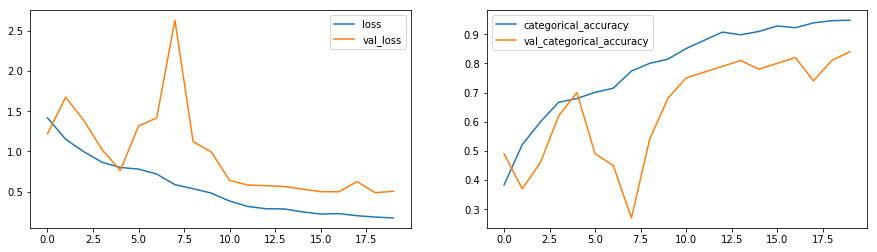

In [20]:
plot(history_model9)

### Model II Experiment [15]

In [21]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

In [22]:
class RNNCNN2(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [23]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_33 (TimeDis (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_34 (TimeDis (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_35 (TimeDis (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_36 (TimeDis (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_37 (TimeDis (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_38 (TimeDis (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_39 (TimeDis (None, 18, 30, 30, 64)    18496     
__________

In [24]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model17=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 2573541
Epoch 1/20
34/34 [==============================] - 107s 3s/step - loss: 1.5441 - categorical_accuracy: 0.3271 - val_loss: 1.2014 - val_categorical_accuracy: 0.5700

Epoch 00001: saving model to model_init_2020-03-3011_24_13.236891/model-00001-1.53674-0.33107-1.20136-0.57000.h5
Epoch 2/20
34/34 [==============================] - 99s 3s/step - loss: 1.1142 - categorical_accuracy: 0.5614 - val_loss: 1.1158 - val_categorical_accuracy: 0.5200

Epoch 00002: saving model to model_init_2020-03-3011_24_13.236891/model-00002-1.09968-0.56712-1.11585-0.52000.h5
Epoch 3/20
34/34 [==============================] - 101s 3s/step - loss: 0.9488 - categorical_accuracy: 0.6372 - val_loss: 0.9338 - val_categorical_accuracy: 0.6800

Epoch 00003: saving model to model_init_2020-03-3011_24_13.236891/model-00003-0.93808-0.64480-0.93376-0.68000.h5
Epoch 4/20
34/34 [==============================] - 102s 3s/step - loss: 0.7743 - categorical_accuracy: 0.7163 - val_loss: 0.8416 - val_catego

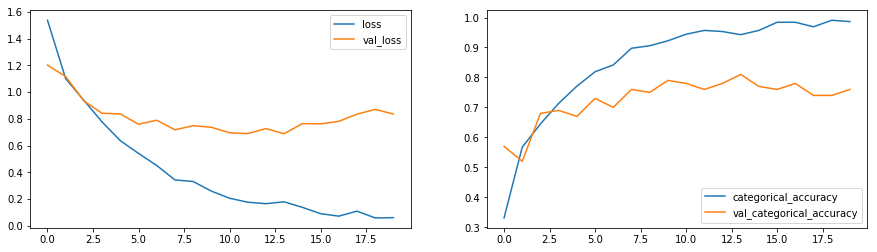

In [25]:
plot(history_model17)

### Model II Experiment [16]

In [26]:
from keras.applications import mobilenet

In [27]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17227776/17225924 [==============================] - 2s 0us/step


In [28]:
rnn_cnn_tl=RNNCNN_TL()
rnn_cnn_tl.initialize_path(project_folder)
rnn_cnn_tl.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_46 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_47 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_48 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_49 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               590336    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
__________

In [29]:
print("Total Params:", rnn_cnn_tl_model.count_params())
history_model18=rnn_cnn_tl.train_model(rnn_cnn_tl_model,augment_data=True)

Total Params: 3840453
Epoch 1/20
133/133 [==============================] - 159s 1s/step - loss: 1.4646 - categorical_accuracy: 0.3607 - val_loss: 1.3475 - val_categorical_accuracy: 0.4600

Epoch 00001: saving model to model_init_2020-03-3012_00_57.780855/model-00001-1.46489-0.36124-1.34751-0.46000.h5
Epoch 2/20
133/133 [==============================] - 86s 647ms/step - loss: 1.2388 - categorical_accuracy: 0.4857 - val_loss: 1.0954 - val_categorical_accuracy: 0.6100

Epoch 00002: saving model to model_init_2020-03-3012_00_57.780855/model-00002-1.23762-0.48718-1.09537-0.61000.h5
Epoch 3/20
133/133 [==============================] - 88s 658ms/step - loss: 1.0489 - categorical_accuracy: 0.5965 - val_loss: 1.1694 - val_categorical_accuracy: 0.5300

Epoch 00003: saving model to model_init_2020-03-3012_00_57.780855/model-00003-1.04566-0.59729-1.16943-0.53000.h5
Epoch 4/20
133/133 [==============================] - 87s 656ms/step - loss: 0.8780 - categorical_accuracy: 0.6572 - val_loss: 1.22

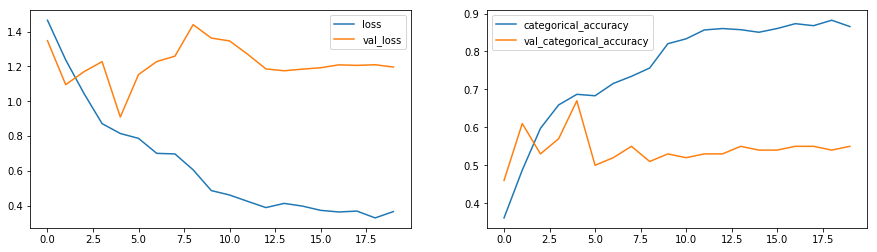

In [30]:
plot(history_model18)

### Model II Experiment [17]

In [31]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [32]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_50 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_51 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_52 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_53 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
__________

In [33]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model19=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3692869
Epoch 1/20
133/133 [==============================] - 105s 791ms/step - loss: 1.3064 - categorical_accuracy: 0.4581 - val_loss: 0.8434 - val_categorical_accuracy: 0.5700

Epoch 00001: saving model to model_init_2020-03-3012_42_10.536697/model-00001-1.30822-0.45701-0.84338-0.57000.h5
Epoch 2/20
133/133 [==============================] - 91s 683ms/step - loss: 0.8285 - categorical_accuracy: 0.6799 - val_loss: 0.6456 - val_categorical_accuracy: 0.7500

Epoch 00002: saving model to model_init_2020-03-3012_42_10.536697/model-00002-0.82922-0.67949-0.64557-0.75000.h5
Epoch 3/20
133/133 [==============================] - 94s 706ms/step - loss: 0.5398 - categorical_accuracy: 0.8033 - val_loss: 0.4915 - val_categorical_accuracy: 0.8400

Epoch 00003: saving model to model_init_2020-03-3012_42_10.536697/model-00003-0.53959-0.80317-0.49151-0.84000.h5
Epoch 4/20
133/133 [==============================] - 95s 712ms/step - loss: 0.4169 - categorical_accuracy: 0.8499 - val_loss: 0

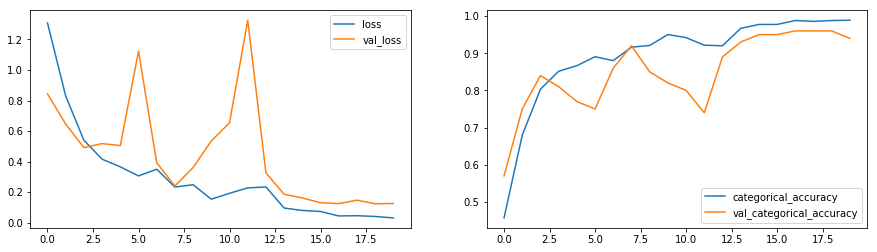

In [34]:
plot(history_model19)

### Model II from experiment 17 (name: "history_model19") is the final selected model with training accuracy of ~99% and validation accuracy of 94%